# Project 3: Sub-reddit Posts Classification



## Problem Statement

In a fast paced society, people have less time to read books and there is a growing trend observed in the amount of people listening to audiobooks instead. A book publishing company is looking to publish a new audiobook. As reddit is a network of communities based on people's interests, two subreddits ['r/audiobooks'](https://www.reddit.com/r/audiobooks/) and ['r/booksuggestions'](https://www.reddit.com/r/booksuggestions/) are chosen in order to understand readers interests in audiobooks. 


## Overview

In this project, data collection was done by doing web scrapping on the both subreddits site. Data obtain consists of all the information of the post and we are going to look into the `selftext` of the posts and carry out classification. Beside classification, we would also try to get some insight from the content of the posts. 

Data collection part of the project are included in 'Project 3 Data Collection' notebook.


## Content
- [Imports](#Imports)
     - Imports all the library that are needed
- [Data Cleaning & Exploratory Data Analysis](#Data-Cleaning-&-EDA)
     - Perform data cleaning and EDA to further understand the data before using it as the features
- [Modeling & Evaluation](#Modeling-&-Evaluation)
     - Transform the data with CountVectorizer and TF-IDF Vectorizer
     - Fit tranformed data in models with best parameters 
     - Select best model and performed gridsearch in order to find out the best parameters for vectorizer
     - Select the best model 
- [Recommendation & Conclusion](#Recommendation-&-Conclusion)
     - Provide recommendation based on the insight provided.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import nltk

plt.style.use('ggplot') 

In [89]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup  
from nltk.corpus import stopwords # Import the stopword list
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS

## Data Cleaning & EDA

In data collection part, web scrapping was done for both subreddits. To avoid duplicate data, `drop_duplicate` done for both datasets collected from two subreddits : 
1. audiobooks saved to audiobook_1.csv 
2. booksuggestions saved to booksuggestion_1.csv

Also, a (combinedbook.csv) dataset was created by combining only the `subreddit` column and `selftext` column from both datasets.

In [3]:
# read in audiobook dataset.
aubook = pd.read_csv('audiobook_1.csv')
aubook.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,num_crossposts,media,is_video,post_hint,preview,link_flair_template_id,crosspost_parent_list,url_overridden_by_dest,crosspost_parent,author_cakeday
0,NaN,audiobooks,I am a 24f and I only listen to audiobooks wit...,t2_3933piuh,False,NaN,0,False,Is anyone else weird like me when it comes to ...,[],...,0,NaN,False,NaN,NaN,36fa779c-80d6-11e4-9559-22000b3617ab,NaN,NaN,NaN,NaN
1,NaN,audiobooks,I am using the app Libby to listen to audioboo...,t2_415dp1oy,False,NaN,0,False,Obtaining a digital library card,[],...,0,NaN,False,NaN,NaN,36fa779c-80d6-11e4-9559-22000b3617ab,NaN,NaN,NaN,NaN
2,NaN,audiobooks,Is there a way to bookmark where i am in a aud...,t2_5tei9wlk,False,NaN,0,False,About Groove music,[],...,0,NaN,False,NaN,NaN,36fa779c-80d6-11e4-9559-22000b3617ab,NaN,NaN,NaN,NaN
3,NaN,audiobooks,"Hi all,\n\n""The Zombie Letters"" by Billie Dean...",t2_13igm1,False,NaN,0,False,"[FREE US &amp; UK Promotion for ""The Zombie Le...",[],...,0,NaN,False,NaN,NaN,2bf22082-8f52-11e3-8877-12313d224170,NaN,NaN,NaN,NaN
4,NaN,audiobooks,If anyone watches the movies 'The Grand Budape...,t2_4i02pdrl,False,NaN,0,False,Narrated by Jude Law?,[],...,0,NaN,False,self,{'images': [{'source': {'url': 'https://extern...,bc43e32c-063a-11e5-a69f-0e874b638b83,NaN,NaN,NaN,NaN


In [4]:
# read in booksuggestion dataset.
booksug = pd.read_csv('booksuggestion_1.csv')
booksug.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,post_hint,preview,author_cakeday
0,NaN,booksuggestions,Hi! Looking for stories concerning pirates. So...,t2_3a29jo3g,False,NaN,0,False,Any Pirate books?,[],...,False,https://www.reddit.com/r/booksuggestions/comme...,340493,1.598992e+09,0,NaN,False,NaN,NaN,NaN
1,NaN,booksuggestions,I know this sounds weird. „What kind of wild m...,t2_37beow9v,False,NaN,0,False,"Fantasy, Magic, Mythology and Science Fiction,...",[],...,False,https://www.reddit.com/r/booksuggestions/comme...,340493,1.598991e+09,0,NaN,False,NaN,NaN,NaN
2,NaN,booksuggestions,I feel like this is either very common or very...,t2_gveh3g,False,NaN,0,False,Nonfiction that reads like narrative fiction,[],...,False,https://www.reddit.com/r/booksuggestions/comme...,340493,1.598991e+09,0,NaN,False,NaN,NaN,NaN
3,NaN,booksuggestions,Recently I started school from 8 to 3 with 15 ...,t2_5qsrmgx6,False,NaN,0,False,What are some easy reads,[],...,False,https://www.reddit.com/r/booksuggestions/comme...,340493,1.598976e+09,0,NaN,False,NaN,NaN,NaN
4,NaN,booksuggestions,I enjoyed it personally,t2_85nrd,False,NaN,0,False,Military Sci-Fi books like Starship Troopers,[],...,False,https://www.reddit.com/r/booksuggestions/comme...,340493,1.598988e+09,0,NaN,False,NaN,NaN,NaN


### Creating wordcloud to visualise content of both subreddits 

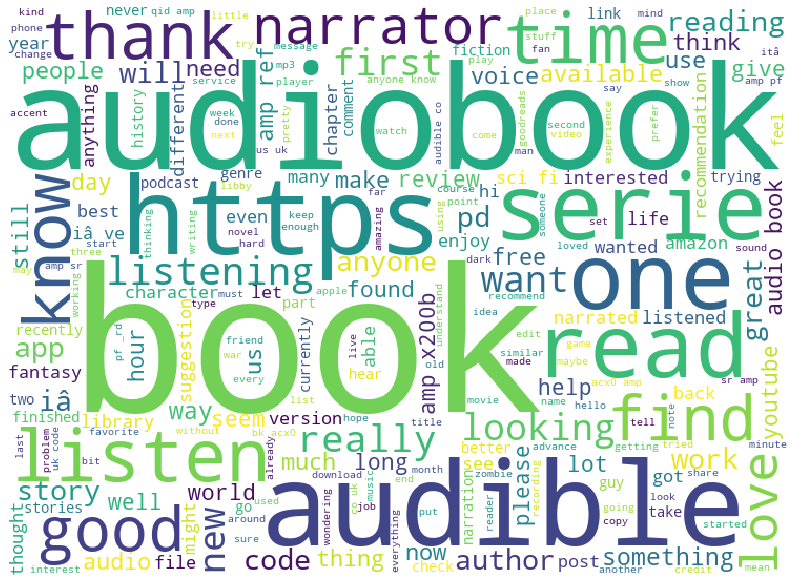

In [5]:
# Create wordcloud for audiobooks dataset
wc_df = pd.read_csv('audiobook_1.csv', encoding ='latin-1') 
text = ' '
stopword = set(STOPWORDS) 
  
for x in wc_df['selftext']:        # iterate through the csv file 
    x = str(x)                     # convert all the content to string 
    values = x.split()             # split the content
    for i in range(len(values)): 
        values[i] = values[i].lower() # Converts each word into lowercase 
    for words in values: 
        text = text + words + ' '
        
wc = WordCloud(max_words= 300,
                      width = 744, 
                      height = 544,
                      background_color ='white',
                      stopwords=stopword, 
                      contour_width=3, 
                      contour_color='steelblue',
                      min_font_size = 10).generate(text)  
                      
plt.figure(figsize = (14, 14))        # plot the WordCloud image  
plt.imshow(wc) 
plt.axis("off")
plt.savefig('audiobook_wordcloud.png')   # save wordcloud as png file

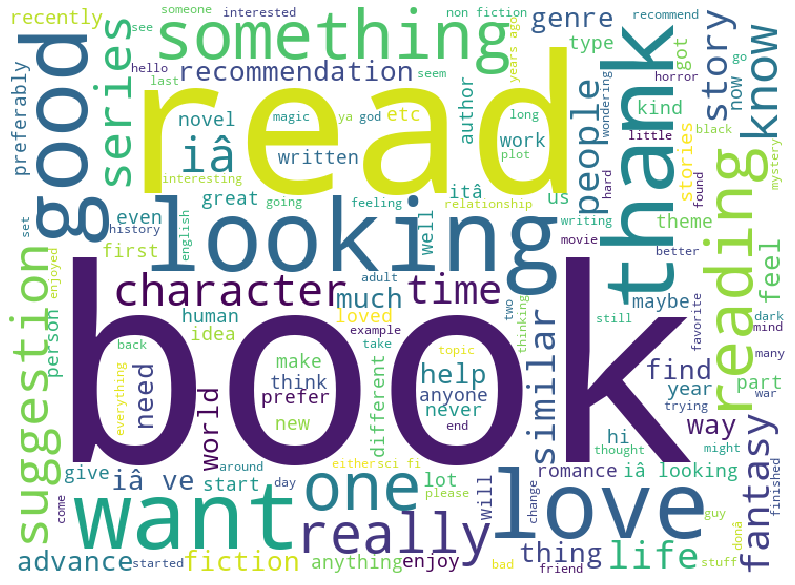

In [6]:
# Create wordcloud for booksuggestions dataset
wc_df = pd.read_csv('booksuggestion_1.csv', encoding ='latin-1') 
text = ' '
stopword = set(STOPWORDS) 
  
for x in wc_df['selftext']:      # iterate through the csv file 
    x = str(x)                   # convert all the content to string   
    values = x.split()           # split the value
    for i in range(len(values)): 
        values[i] = values[i].lower() # Converts each word into lowercase   
    for words in values: 
        text = text + words + ' '
        
wc = WordCloud(max_words= 300,
                      width = 744, 
                      height = 544,
                      background_color ='white',
                      stopwords=stopword, 
                      contour_width=3, 
                      contour_color='steelblue',
                      min_font_size = 10).generate(text) 
                         
plt.figure(figsize = (14, 14))    # plot the WordCloud image 
plt.imshow(wc) 
plt.axis("off")
plt.savefig('booksuggestions_wordcloud.png')  # save wordcloud as png file

By looking at both wordclouds, we can easily differentiate the difference between two subreddits as there are some keywords appeared frequently in the posts:
- audiobook, audible, https, listening from subreddit `audiobooks`
- looking, read, reading from subreddit `booksuggestions`

In audiobooks subreddit, people are usually sharing the links to get free audiobook as words like 'audible' and 'https' are the frequently appeared words. However, in booksuggestions subreddit, people usually ask for recommendation of books for reading as 'suggestion' is one of the frequently appeared words. 


As there are some obvious words that appear in the subreddits and it can be easily use to identify the subreddit that it belongs to, we might need to check the frequency of the word appearing in the content and if the frequency is too high, we can add the words into the `stopwords` list so that we will not take that word to train our model.

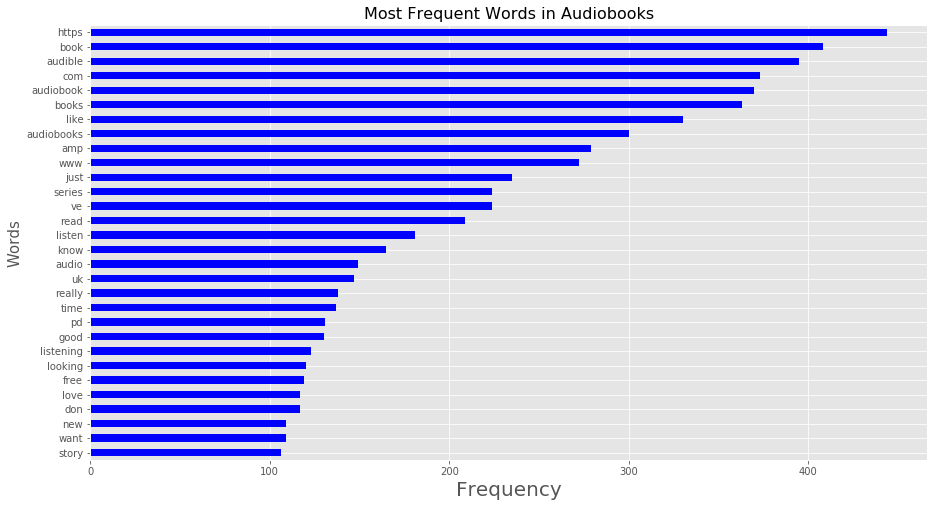

In [107]:
# barplot to show the frequency of the word appear in audiobooks

# intialized CountVectorizer, fit and transform
cvec = CountVectorizer(stop_words = 'english')   # remove stopwords
cvec.fit(aubook['selftext'])
selftext_t = cvec.transform(aubook['selftext'])

# Making it into a DataFrame
selftext_t_df = pd.DataFrame(selftext_t.toarray(),columns = cvec.get_feature_names())
    
# Plot the barchart
plt.figure(figsize=(15,8))
plt.xlabel('Frequency', size = 20)
plt.ylabel('Words', size = 15)
plt.title(f'Most Frequent Words in Audiobooks', size = 16)
    
selftext_t_df.sum().sort_values(ascending=True).tail(30).plot(kind='barh', color = 'b');  

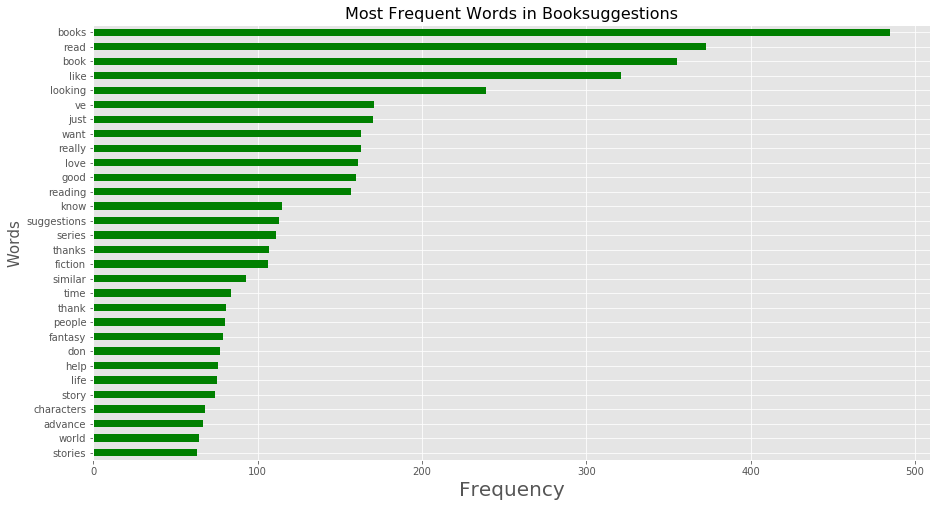

In [108]:
# barplot to show the frequency of the word appear in booksuggestions

# intialized CountVectorizer, fit and transform
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(booksug['selftext'])
selftext_t = cvec.transform(booksug['selftext'])

# Making it into a DataFrame
selftext_t_df = pd.DataFrame(selftext_t.toarray(),columns = cvec.get_feature_names())
    
# Plot the barchart
plt.figure(figsize=(15,8))
plt.xlabel('Frequency', size = 20)
plt.ylabel('Words', size = 15)
plt.title(f'Most Frequent Words in Booksuggestions', size = 16)
    
selftext_t_df.sum().sort_values(ascending=True).tail(30).plot(kind='barh', color = 'g');  

Based on the wordcloud and the word count bar plot, some of the words that frequently appeared can be added in to stopwords list so that we do not use it as a feature to train our model.
            
      audible, audiobook, audiobooks, listen, listens, listening, audio, read, reads, reading, book, books, https, com, www

### Read in the combinedbook dataset and do data cleaning and preprocessing

In [9]:
df = pd.read_csv('combinedbook.csv')

In [10]:
df.head()

,subreddit,selftext
0,audiobooks,I am a 24f and I only listen to audiobooks wit...
1,audiobooks,I am using the app Libby to listen to audioboo...
2,audiobooks,Is there a way to bookmark where i am in a aud...
3,audiobooks,"Hi all,\n\n""The Zombie Letters"" by Billie Dean..."
4,audiobooks,If anyone watches the movies 'The Grand Budape...


In [11]:
# Checking for null
df['selftext'].isnull().sum()

0

In [12]:
# Convert subreddit into binary labels
df['subreddit_bi'] = df['subreddit'].map({'audiobooks': 1, 'booksuggestions': 0})
df.head()

,subreddit,selftext,subreddit_bi
0,audiobooks,I am a 24f and I only listen to audiobooks wit...,1
1,audiobooks,I am using the app Libby to listen to audioboo...,1
2,audiobooks,Is there a way to bookmark where i am in a aud...,1
3,audiobooks,"Hi all,\n\n""The Zombie Letters"" by Billie Dean...",1
4,audiobooks,If anyone watches the movies 'The Grand Budape...,1


- As we are interested in audiobooks, class 1 is audiobooks and class 0 is booksuggestions. However, we dont mind getting informations from class 0 as well. For better, we would prefer less number of wrongly classified the posts that belongs to class 1(audiobooks) to class 0 (booksuggestions). Thus, we would want lesser no.of false negative in this case.

### Train Test Split

In [13]:
X = df[['selftext']]
y = df['subreddit_bi']

In [14]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,    # 70% as training data, 30% as validation data
                                                    stratify=y,       # to keep the dataset ratio
                                                    random_state=42)

In [15]:
X_train.shape

(937, 1)

In [16]:
X_test.shape

(402, 1)

In [17]:
X_train

,selftext
591,Any recommendations for good audiobooks for wh...
621,Hello everyone! I'm a writer of horror (and a ...
892,Ever been in an interesting conversation where...
488,"I do chores, walks, stretching and cross-stich..."
1093,"I’ve heard Think by Simon Blackburn is good, a..."
...,...
691,Recently I started school from 8 to 3 with 15 ...
872,"Hello, I'm looking for a book on recent Chines..."
627,"I like to crochet, so now I have this hideous ..."
1311,I’m honestly trying to read something new. I h...


### Cleaning with Stemming or Lematize

In [18]:
# download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\xing
[nltk_data]     wei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# Updating stopwords list with frequent words define above
stops = set(stopwords.words('english'))   
list_stop = ['audible', 'audiobook', 'audiobooks', 'listen', 'listens', 'listening', 'audio', 
             'read', 'reads', 'reading', 'book', 'books', 'https', 'com', 'www']
stops.update(list_stop)

In [20]:
# Function for cleaning with STEMMING

def clean_words_stem(raw_selftext):
     
    selftext_text = BeautifulSoup(raw_selftext).get_text()    # 1. Remove HTML.
    letters_only = re.sub("[^a-zA-Z]", " ", selftext_text)    # 2. Remove non-letters.
    words = letters_only.lower().split()                      # 3. Convert to lower case, split into individual words.
    meaningful_words = [w for w in words if w not in stops]   # 4. Remove stopwords.
    p_stemmer = PorterStemmer()                               # 5. Stemming
    meaningful_words_stemmed = [p_stemmer.stem(w) for w in meaningful_words]    
    
    return(" ".join(meaningful_words_stemmed))   # 6. Join the words back into one string separated by space,return the result.

In [21]:
# Get the number of selftext based on the dataframe size.
total_selftext = df.shape[0]
print(f'There are {total_selftext} selftext.')

There are 1339 selftext.


In [22]:
# Initialize an empty list to hold the clean selftext.
Xtrain_stem = []
Xtest_stem = []

print("Cleaning and parsing the training set selftext...")

j = 0   # Instantiate counter.

# For every selftext in training set...
for train_selftext in X_train['selftext']:  
    Xtrain_stem.append(clean_words_stem(train_selftext))  # Convert selftext to words,append to clean_train_selftext.
    if (j + 1) % 500 == 0:
        print(f'Selftext {j + 1} of {total_selftext}.')    # If the index is divisible by 500, print a message.
    j += 1

# Do the same for testing set.
print("Cleaning and parsing the testing set selftext...")   

for test_selftext in X_test['selftext']:
    Xtest_stem.append(clean_words_stem(test_selftext)) 
    if (j + 1) % 500 == 0:
        print(f'Selftext {j + 1} of {total_selftext}.')      
    j += 1

Cleaning and parsing the training set selftext...


C:\Users\xing wei\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.amazon.com/9-Incarnate-Gary-Starta-audiobook/dp/B07MCMM21F" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\xing wei\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://en.m.wikipedia.org/wiki/Farsala_Trilogy" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Selftext 500 of 1339.


C:\Users\xing wei\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.audible.com/pd/B0874TNSSG/?source_code=AUDFPWS0223189MWT-BK-ACX0-191987&amp;ref=acx_bty_BK_ACX0_191987_rh_us" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Cleaning and parsing the testing set selftext...
Selftext 1000 of 1339.


C:\Users\xing wei\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.youtube.com/watch?v=okEwvKat59Q&amp;feature=youtu.be&amp;fbclid=IwAR1Cm8Llg_uDPDLmmYqtCpPKEQt4dXnfS2hMv8LPlFS1fe1RmfPTzYtHX-k" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [23]:
# Function for cleaning with Lemmatize

def clean_words_lem(raw_selftext):
    
    selftext_text = BeautifulSoup(raw_selftext).get_text()    # 1. Remove HTML.
    letters_only = re.sub("[^a-zA-Z]", " ", selftext_text)    # 2. Remove non-letters.
    words = letters_only.lower().split()                      # 3. Convert to lower case, split into individual words.
    meaningful_words = [w for w in words if w not in stops]   # 4. Remove stopwords.
    lemmatizer = WordNetLemmatizer()                          # 5. Lemmatize
    meaningful_words_lemmatized = [lemmatizer.lemmatize(w) for w in meaningful_words]   
    
    return(" ".join(meaningful_words_lemmatized))  # 6.Join the words back into one string separated by space,return the result.

In [24]:
# Initialize an empty list to hold the clean selftext.
Xtrain_lem = []
Xtest_lem = []

print("Cleaning and parsing the training set selftext...")

j = 0     # Instantiate counter.

# For every selftext in training set...
for train_selftext in X_train['selftext']:
    Xtrain_lem.append(clean_words_lem(train_selftext)) # Convert selftext to words,append to clean_train_selftext.
    if (j + 1) % 500 == 0:
        print(f'Selftext {j + 1} of {total_selftext}.')    # If the index is divisible by 500, print a message.
    j += 1

# Same for testing set.
print("Cleaning and parsing the testing set selftext...")

for test_selftext in X_test['selftext']:
    Xtest_lem.append(clean_words_lem(test_selftext))
    if (j + 1) % 500 == 0:
        print(f'Selftext {j + 1} of {total_selftext}.')    
    j += 1

Cleaning and parsing the training set selftext...
Selftext 500 of 1339.
Cleaning and parsing the testing set selftext...
Selftext 1000 of 1339.


In [26]:
# Checking some example after stemming and lemmatize
print('Stemmed: ')
print(Xtrain_stem[5])
print('')
print('Lemmatized: ')
print(Xtrain_lem[5])

Stemmed: 
decid pick bunch titl tom clanci jack ryan seri one librari alreadi clear present danger brillianc list unabridg narrat j charl appear convert cd version clock hour minut longer avail sale via though still download look seri notic new version clear present danger avail via aubil pd clear present danger b ebz gi qid sr ref search c lproduct pf rd p e b c b cef fe pf rd r ea hwxgv z xk cgbh random hous narrat michael prichard clock littl hour anyon idea hour differ two seem like big differ chalk simpli narrat style realli plan pick new one especi see review regard narrat wonder someth miss version alreadi

Lemmatized: 
decided pick bunch title tom clancy jack ryan series one library already clear present danger brilliance listed unabridged narrated j charles appears converted cd version clock hour minute longer available sale via though still download looking series noticed new version clear present danger available via aubile pd clear present danger b ebz gi qid sr ref search 

In this case, stemming removed the last few characters of a word, and it leads to incorrect meanings and spelling. However, lemmatization did consider the context and converts the word to its meaningful base form. 

Based on above example, we will choose the cleaned data after lemmatization because there might be some specific word that is valuable information representing the names of authors and book titles. 

## Modeling & Evaluation

### Baseline accuracy

The baseline of the classification will be classifing the words or post as majority class.

In [27]:
# Baseline Accuracy
y.value_counts(normalize=True)

1    0.513816
0    0.486184
Name: subreddit_bi, dtype: float64

Baseline accuracy is 51.38% as to classify words belong to class 1 which is subreddit `audiobooks` in this case.

### Count Vectorizer

In [28]:
# CountVectorizer with default parameters and max_features 5000
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,   # since we already cleaned the data before
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)  # set maximun features

In [29]:
# Fit and tranform lemmatized data to features
Xtrain_cvec = vectorizer.fit_transform(Xtrain_lem)
Xtest_cvec = vectorizer.transform(Xtest_lem)

print(Xtrain_cvec.shape)
print(Xtest_cvec.shape)

(937, 5000)
(402, 5000)


In [30]:
# make a dataframe with vectorized words
cvec_df = pd.DataFrame(Xtrain_cvec.toarray(), columns=vectorizer.get_feature_names()).head()
cvec_df.head()

,aa,aac,aax,abbey,abcdef,abercrombie,ability,able,abridged,absolutely,...,zoey,zombie,zone,zoom,zp,zqn,zsep,zsrtxldarutsatnzvb,zufelt,zusak
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Checking the vocab after vectorized
vocab = vectorizer.get_feature_names()
print(vocab)

['aa', 'aac', 'aax', 'abbey', 'abcdef', 'abercrombie', 'ability', 'able', 'abridged', 'absolutely', 'absorbing', 'academic', 'academy', 'accent', 'accept', 'access', 'accessible', 'acclaimed', 'accomplished', 'according', 'account', 'accurate', 'ace', 'achieve', 'achilles', 'acnq', 'acotar', 'across', 'act', 'acting', 'action', 'activation', 'active', 'activity', 'actor', 'actress', 'actual', 'actually', 'acx', 'ad', 'adam', 'adaptation', 'adbl', 'add', 'added', 'addict', 'addicted', 'addiction', 'adding', 'additional', 'additionally', 'address', 'adhd', 'adjust', 'adnan', 'adopt', 'adored', 'adult', 'advance', 'advanced', 'advancement', 'advantage', 'adventure', 'adventurous', 'adversary', 'advertisement', 'advertising', 'advice', 'advise', 'ae', 'aencv', 'aesopplayer', 'affair', 'affected', 'affiliated', 'afford', 'afraid', 'africa', 'african', 'agatha', 'age', 'aged', 'agenda', 'agent', 'ago', 'agricultural', 'ahead', 'air', 'airborn', 'airship', 'airtable', 'al', 'alanson', 'albert

### Logistic Regression_Count Vectorizer

#### GridSearch for best parameter of Logistic Regression

In [32]:
# Search parameter range
# Alpha : 0.001 to 10
# Class weight: none or balanced
# Penalty: Lasso or Ridge
logreg_parameters = {'C': [0.001, 0.01, 0.1, 1, 10],
              'class_weight': [None, 'balanced'],
              'penalty': ['l1', 'l2']}

In [33]:
logreg_gs_results = GridSearchCV(estimator = LogisticRegression(solver='liblinear'), # Specify the model to GridSearch.
                          param_grid = logreg_parameters,                            # Specify the grid of parameters to search.
                          scoring = 'recall',                                        # Specify recall as the metric to optimize 
                          cv = 5).fit(Xtrain_cvec, y_train)                          # Set 5-fold cross-validation, then fit. 

In [34]:
# Find out the best parameters
logreg_gs_results.best_estimator_

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

- Best parameters for Logistic Regression: alpha = 0.001, class_weight = None, penalty = Ridge

#### Apply Logistic Regression with best estimator

In [35]:
# Fit and score the model
lr_cvec = LogisticRegression(C=0.001, class_weight= None, penalty = 'l2', solver='liblinear')

lr_cvec.fit(Xtrain_cvec, y_train)

print('Logistic Regression CVEC Training accuracy : ' + str(lr_cvec.score(Xtrain_cvec, y_train)))
print('Logistic Regression CVEC Testing accuracy : ' + str(lr_cvec.score(Xtest_cvec, y_test)))

Logistic Regression CVEC Training accuracy : 0.8185699039487727
Logistic Regression CVEC Testing accuracy : 0.7761194029850746


Logistic Regression CVEC is overfitting with testing accuracy of 0.7761.

In [36]:
# Check on the confusion matrix
confusion_matrix(y_test, lr_cvec.predict(Xtest_cvec))

array([[137,  58],
       [ 32, 175]], dtype=int64)

In [37]:
tn, fp, fn, tp = confusion_matrix(y_test,lr_cvec.predict(Xtest_cvec)).ravel()
print("True Negatives: " + str(tn))
print("False Positives: " + str(fp))
print("False Negatives: " + str(fn))
print("True Positives: " + str(tp))

True Negatives: 137
False Positives: 58
False Negatives: 32
True Positives: 175


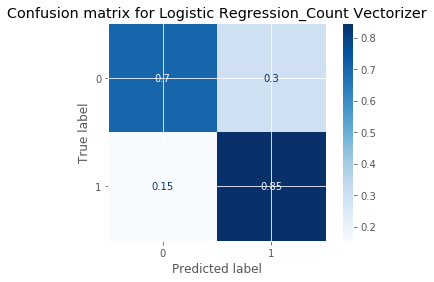

In [38]:
matrix = plot_confusion_matrix(lr_cvec, Xtest_cvec, y_test,
                                 cmap=plt.cm.Blues, normalize='true')
plt.title('Confusion matrix for Logistic Regression_Count Vectorizer')
plt.show(matrix)
plt.show()

Based on the confusion matrix of Logistic Regression_Count Vectorizer:
- 32 posts from class 1 'audiobooks' was wrongly classified as class 0 'booksuggestions'
- 58 posts from class 0 'booksuggestions' was wrongly classified as class 1 'audiobook'

Even though that might not bring too much bad outcome if there is any false positives or false negatives, we would still want to minimised the number of false predictions so that we can get a better performing classification model.

#### Find out the predictor of each subreddit based on logistic regression cvec coef_

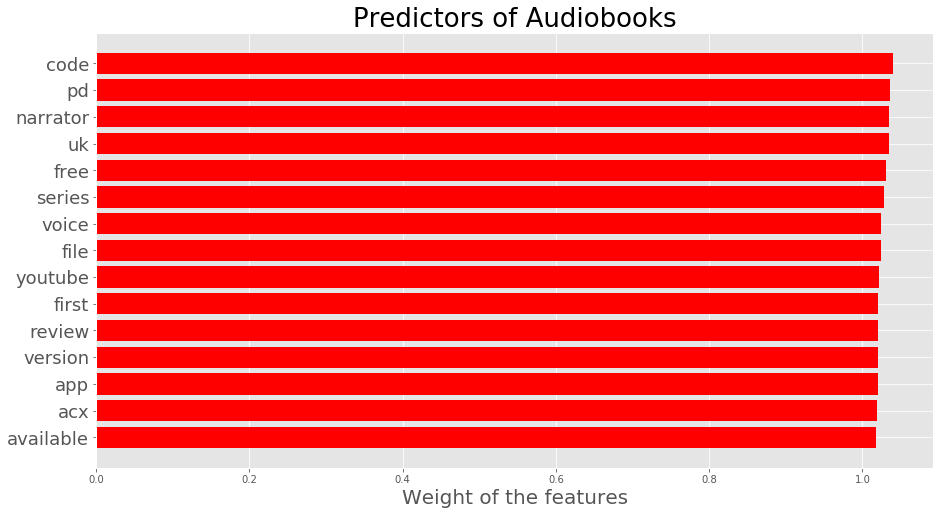

In [109]:
# creating a list of all words being analyzed with their corresponding coefficients from logistic regression
log_coefs = pd.DataFrame(list(zip(cvec_df, np.exp(lr_cvec.coef_[0]))))
# creating a table of the top 15 coefficients and the words they belong to class 1
table = log_coefs.sort_values(1, ascending=False).head(15)

# Create a horizontal barplot
plt.figure(figsize=(15,8))
plt.barh(table[0], table[1], color='r')
# labeling and formatting the y axis
plt.xlabel('Weight of the features', fontsize=20)

# flips the y axis so that the largest bars are on top
plt.ylim(plt.ylim()[::-1])
# setting the font of the yticks
plt.yticks(fontsize=18)
# setting and formatting the title
plt.title('Predictors of Audiobooks', fontsize=26);

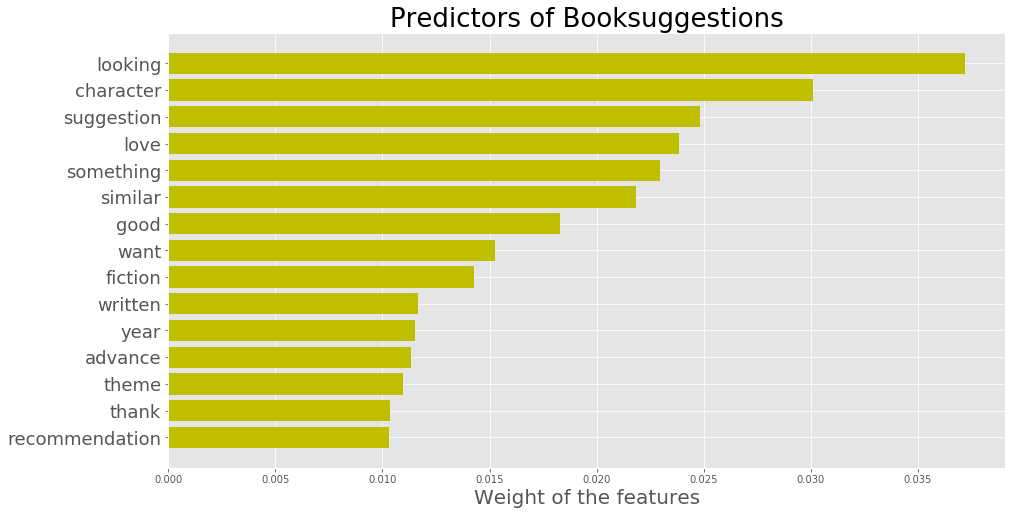

In [40]:
# creating a table of the top 15 coefficients and the words they belong to class 0
table = log_coefs.sort_values(1).head(15)

# Create a horizontal barplot
plt.figure(figsize=(15,8))
# To make the most relevant words as the largest bar as the words would have lowest coefficient with class 1
plt.barh(table[0], (1- table[1]),color='y')
# labeling and formatting the y axis
plt.xlabel('Weight of the features', fontsize=20)

# flips the y axis so that the largest bars are on top
plt.ylim(plt.ylim()[::-1])
# setting the font of the yticks
plt.yticks(fontsize=18)
# setting and formatting the title
plt.title('Predictors of Booksuggestions', fontsize=26);

Preditors of class 0 `audiobooks` have almost equally weight and this might be the reason of false predictions.

By looking on the preditors of each class, the best preditors also can be a words that frequently appear in the subreddits and we can take note when making recommendation. 
- For audiobooks: narrator, free, and youtube. 
- For booksuggestions: love and fiction.

### K-Nearest Neighbors_Count Vectorizer

#### GridSearch for best parameter of K-Nearest Neighbors

In [41]:
# Setting the knn parameters to search the best number of k
knn_parameters = {'n_neighbors': [5, 10, 25, 50]}
# gridsearch and fit 
knn_gs_results = GridSearchCV(estimator = KNeighborsClassifier(),
                              param_grid = knn_parameters,
                              cv = 5).fit(Xtrain_cvec, y_train) 

In [42]:
# best parameters for knn
knn_gs_results.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

- Best estimator for K-Nearest Neighbors : n_neighbors= 25, weights= uniform

#### Apply K-Nearest Neighbors with best estimator

In [43]:
# Fit and score the model
knn_cvec = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                                metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                                weights='uniform')

knn_cvec.fit(Xtrain_cvec, y_train)

print('K-Nearest Neighbors CVEC Training accuracy with k = 25: ' + str(knn_cvec.score(Xtrain_cvec, y_train)))
print('K-Nearest Neighbors CVEC Testing accuracy with k = 25: ' + str(knn_cvec.score(Xtest_cvec, y_test)))

K-Nearest Neighbors CVEC Training accuracy with k = 25: 0.6808964781216649
K-Nearest Neighbors CVEC Testing accuracy with k = 25: 0.6442786069651741


K-Nearest Neighbors CVEC has lower accuracy score as compared to Logistic Regression

In [44]:
# confusion matrix 
confusion_matrix(y_test, knn_cvec.predict(Xtest_cvec))

array([[177,  18],
       [125,  82]], dtype=int64)

In [45]:
tn, fp, fn, tp = confusion_matrix(y_test,knn_cvec.predict(Xtest_cvec)).ravel()
print("True Negatives: " + str(tn))
print("False Positives: " + str(fp))
print("False Negatives: " + str(fn))
print("True Positives: " + str(tp))

True Negatives: 177
False Positives: 18
False Negatives: 125
True Positives: 82


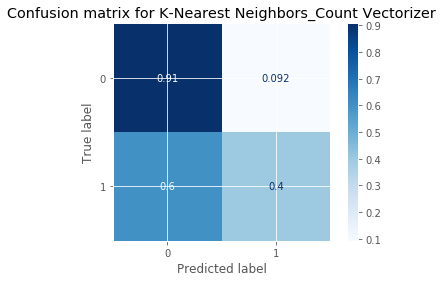

In [46]:
matrix = plot_confusion_matrix(knn_cvec, Xtest_cvec, y_test,
                                 cmap=plt.cm.Blues, normalize='true')
plt.title('Confusion matrix for K-Nearest Neighbors_Count Vectorizer')
plt.show(matrix)
plt.show()

Based on the confusion matrix of K-Nearest Neighbors_Count Vectorizer:
- 125 posts from class 1 'audiobooks' was wrongly classified as class 0 'booksuggestions'
- 18 posts from class 0 'booksuggestions' was wrongly classified as class 1 'audiobook'

The no.of false negatives increased for K-Nearest Neighbors model. Since we do not want high no.of false negatives, this model is not a good model for classification.

### Multinomial Naive Bayes Model_Count Vectorizer

#### Try Multinomial Naive Bayes with all the default parameters

In [47]:
# Fit and score the model
nb_cvec = MultinomialNB()

nb_cvec.fit(Xtrain_cvec, y_train)

print('MultinomialNB CVEC Training accuracy: ' + str(nb_cvec.score(Xtrain_cvec, y_train)))
print('MultinomialNB CVEC Testing accuracy: ' + str(nb_cvec.score(Xtest_cvec, y_test)))

MultinomialNB CVEC Training accuracy: 0.9252934898612594
MultinomialNB CVEC Testing accuracy: 0.8308457711442786


Multinomial Naive Bayes model is still overfiting but it has higher accuracy as compared to Logistic Regression.

In [48]:
# Generate a confusion matrix.
confusion_matrix(y_test, nb_cvec.predict(Xtest_cvec))

array([[174,  21],
       [ 47, 160]], dtype=int64)

In [49]:
tn, fp, fn, tp = confusion_matrix(y_test, nb_cvec.predict(Xtest_cvec)).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 174
False Positives: 21
False Negatives: 47
True Positives: 160


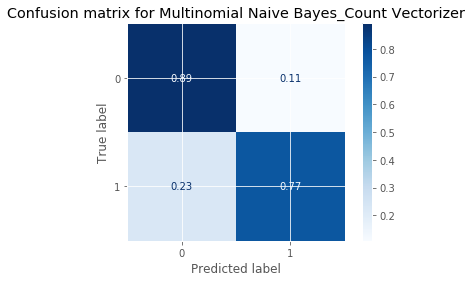

In [50]:
matrix = plot_confusion_matrix(nb_cvec, Xtest_cvec, y_test,
                                 cmap=plt.cm.Blues, normalize='true')
plt.title('Confusion matrix for Multinomial Naive Bayes_Count Vectorizer')
plt.show(matrix)
plt.show()

Confusion Matrix of Multinomial Naive Bayes model:
- 47 posts from class 1 'audiobook' was wrongly classified as class 0 'booksuggestions'
- 21 posts from class 0 'booksuggestions' was wrongly classified as class 1 'audiobook'

Compared to confusion matrix of Logistic Regression, no.of false prediction decrease from 90 to 68. Hence, this model will be the best model with Count Vectorizer.

### Best model with Countvectorizer is Multinomial Naive Bayes model.

GridSearch to find the best parameter of CountVectorizer and fit into the best model.

In [51]:
# Using pipeline, vectorized with best parameters of vectorizer and fit into the model
pipe = Pipeline([('cvec', CountVectorizer()),
                 ('nb', MultinomialNB())])
pipe.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'verbose': False,
 'cvec': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 'nb': M

In [52]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {'cvec__max_features':[2000,3000,4000,5000], 'cvec__min_df': [2,3],
               'cvec__max_df': [0.9,0.95], 'cvec__ngram_range': [(1,1),(1,2)]}

In [53]:
# Instantiate GridSearchCV.
gs = GridSearchCV(pipe,param_grid = pipe_params, cv=5) 

# Fit GridSearch to clean_training data.
gs.fit(Xtrain_lem,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [54]:
# Best score among the models 
print('CVEC MultinomialNB Best Score: ' + str(gs.best_score_))

# Best hyperparameter used
print('CVEC MultinomialNB Best Hyperparameters: ' +str(gs.best_params_))

CVEC MultinomialNB Best Score: 0.8228126066674253
CVEC MultinomialNB Best Hyperparameters: {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}


In [55]:
# Save best model as gs_model.
gs_nb_cvec_model = gs.best_estimator_

# Score model on training set.
print('GSCVEC MultinomialNB Training accuracy: ' + str(gs_nb_cvec_model.score(Xtrain_lem, y_train)))

# Score model on testing set.
print('GSCVEC MultinomialNB Testing accuracy: ' + str(gs_nb_cvec_model.score(Xtest_lem, y_test)))

GSCVEC MultinomialNB Training accuracy: 0.9295624332977588
GSCVEC MultinomialNB Testing accuracy: 0.8208955223880597


### Evaluate the models with Count Vectorizer

Multinomial Naive Bayes_Count Vectorizer with max_features=5000,
- MultinomialNB CVEC Training accuracy: 0.9252934898612594
- MultinomialNB CVEC Testing accuracy: 0.8308457711442786

Multinomial Naive Bayes_GridSearch Count Vectorizer with best parameters,
- GSCVEC MultinomialNB Training accuracy: 0.9295624332977588
- GSCVEC MultinomialNB Testing accuracy: 0.8208955223880597

By only using the hyperparameter of max_features=5000 for Count Vectorizer, the model has higher testing accuracy and less overfit. Thus, best model with Count Vectorizer is Multinomial Naive Bayes.

### TF-IDF Vectorizer

In [56]:
# TF-IDF Vectorizer with default parameters and max_features 5000
tvec = TfidfVectorizer(max_features=5000)

In [57]:
# Fit and tranform to features
Xtrain_tvec = tvec.fit_transform(Xtrain_lem)
Xtest_tvec = tvec.transform(Xtest_lem)

print(Xtrain_tvec.shape)
print(Xtest_tvec.shape)

(937, 5000)
(402, 5000)


In [59]:
# make dataframe with the features
tvec_df = pd.DataFrame(Xtrain_tvec.toarray(),
                  columns=tvec.get_feature_names())
tvec_df.head()

,aa,aac,aax,abbey,abcdef,abercrombie,ability,able,abridged,absolutely,...,zoey,zombie,zone,zoom,zp,zqn,zsep,zsrtxldarutsatnzvb,zufelt,zusak
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.124056,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic Regression_TF-IDF Vectorizer

#### GridSearch for best parameters of Logistic Regression

In [60]:
# Search parameter range
# Alpha : 0.001 to 10
# Class weight: none or balanced
# Penalty: Lasso or Ridge
logreg_parameters = {'C': [0.001, 0.01, 0.1, 1, 10],
              'class_weight': [None, 'balanced'],
              'penalty': ['l1', 'l2']}

In [61]:
# Gridsearch and fit
logreg_gs_results = GridSearchCV(estimator = LogisticRegression(max_iter=10000,solver='liblinear'), 
                          param_grid = logreg_parameters,                     
                          scoring = 'recall',                                
                          cv = 5).fit(Xtrain_tvec, y_train)                    

In [62]:
# Best parameter
logreg_gs_results.best_estimator_

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

- Best parameters for Logistic Regression: alpha = 0.001, class_weight = None, penalty = Ridge

#### Apply Logistic Regression with best estimator

In [63]:
# fit and score the model
lr_tvec = LogisticRegression(C=0.001, class_weight= None, penalty = 'l2', solver='liblinear')

lr_tvec.fit(Xtrain_tvec, y_train)

print('Logistic Regression TVEC Training accuracy : ' + str(lr_tvec.score(Xtrain_tvec, y_train)))
print('Logistic Regression TVEC Testing accuracy : ' + str(lr_tvec.score(Xtest_tvec, y_test)))

Logistic Regression TVEC Training accuracy : 0.5133404482390609
Logistic Regression TVEC Testing accuracy : 0.5149253731343284


Logistic Regression with TF-IDF Vectorizer has a very low accuracy score.

In [64]:
# Confusion matrix
confusion_matrix(y_test, lr_tvec.predict(Xtest_tvec))

array([[  0, 195],
       [  0, 207]], dtype=int64)

In [65]:
tn, fp, fn, tp = confusion_matrix(y_test,lr_tvec.predict(Xtest_tvec)).ravel()
print("True Negatives: " + str(tn))
print("False Positives: " + str(fp))
print("False Negatives: " + str(fn))
print("True Positives: " + str(tp))

True Negatives: 0
False Positives: 195
False Negatives: 0
True Positives: 207


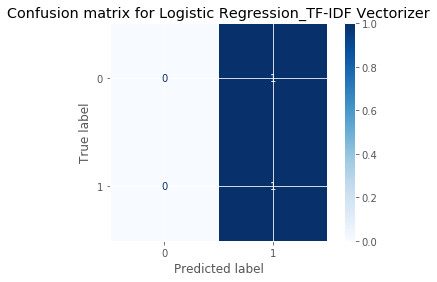

In [66]:
matrix = plot_confusion_matrix(lr_tvec, Xtest_tvec, y_test,
                                 cmap=plt.cm.Blues, normalize='true')
plt.title('Confusion matrix for Logistic Regression_TF-IDF Vectorizer')
plt.show(matrix)
plt.show()

Confusion Matrix of Logistic Regression model:
- 195 posts from class 1 'booksuggestions' was wrongly classified as class 0 'audiobook'

This model classify all of the posts to be class 0.

#### Find out the predictor of each subreddit based on logistic regression tvec coef_

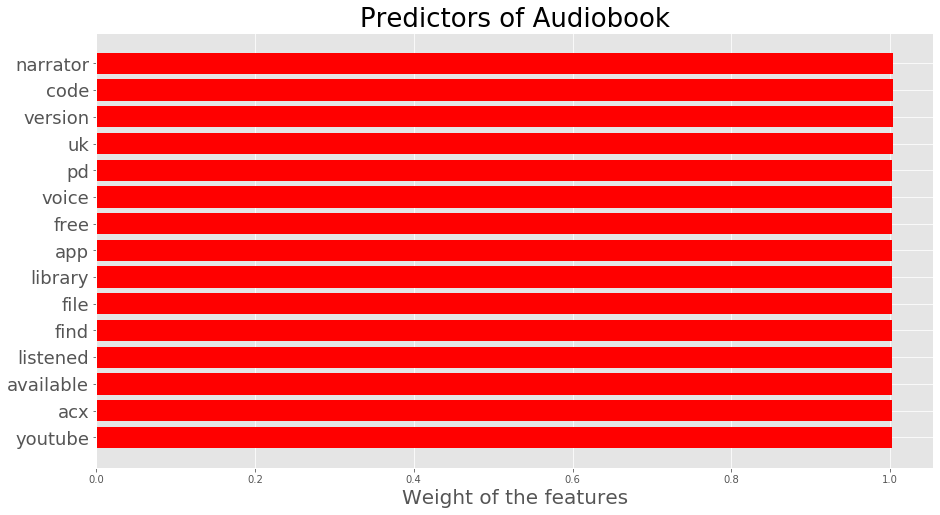

In [67]:
# creating a list of all words being analyzed with their corresponding coefficients from logistic regression
logt_coefs = pd.DataFrame(list(zip(tvec_df, np.exp(lr_tvec.coef_[0]))))
# creating a table of the top 15 coefficients and the words they belong to class 0
table = logt_coefs.sort_values(1, ascending=False).head(15)

# Create a horizontal barplot
plt.figure(figsize=(15,8))
# To make the most relevant words as the largest bar
plt.barh(table[0], table[1],color='r')
# labeling and formatting the y axis
plt.xlabel('Weight of the features', fontsize=20)

# flips the y axis so that the largest bars are on top
plt.ylim(plt.ylim()[::-1])
# setting the font of the yticks
plt.yticks(fontsize=18)
# setting and formatting the title
plt.title('Predictors of Audiobook', fontsize=26);

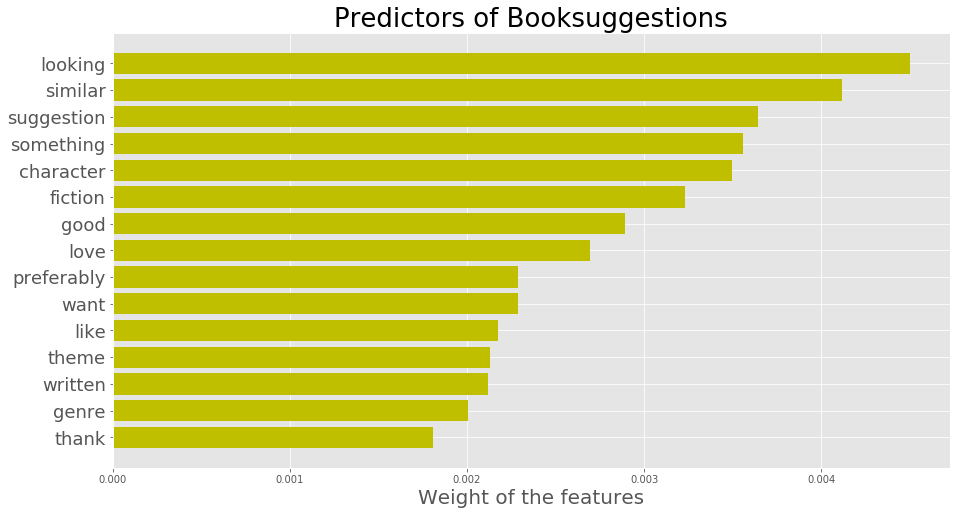

In [68]:
# creating a table of the top 15 coefficients and the words they belong to
table = logt_coefs.sort_values(1).head(15)

# Create a horizontal barplot
plt.figure(figsize=(15,8))
plt.barh(table[0], (1-table[1]),color='y')
# labeling and formatting the y axis
plt.xlabel('Weight of the features', fontsize=20)

# flips the y axis so that the largest bars are on top
plt.ylim(plt.ylim()[::-1])
# setting the font of the yticks
plt.yticks(fontsize=18)
# setting and formatting the title
plt.title('Predictors of Booksuggestions', fontsize=26);

Based on the bar plot above, preditors of class 0 audiobooks have almost equally weight and this might be the reason of false predictions as there are no significant words can be use for classification.

### K-Nearest Neighbors_TF-IDF Vectorizer

#### GridSearch for best parameter of K-Nearest Neighbors

In [69]:
# Setting the knn parameters to search the best number of k
knn_parameters = {'n_neighbors': [5, 10, 25, 50]}

# Grid search 
knn_gs_results = GridSearchCV(estimator = KNeighborsClassifier(),
                              param_grid = knn_parameters,
                              cv = 5).fit(Xtrain_tvec, y_train) 

In [70]:
# best parameter
knn_gs_results.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

- Best estimator for K-Nearest Neighbors : n_neighbors= 25, weights= uniform

#### Apply K-Nearest Neighbors with best estimator

In [71]:
# Fit and score the model
knn_tvec = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                                metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                                weights='uniform')

knn_tvec.fit(Xtrain_tvec, y_train)

print('K-Nearest Neighbors TVEC Training accuracy with k = 25: ' + str(knn_tvec.score(Xtrain_tvec, y_train)))
print('K-Nearest Neighbors TVEC Testing accuracy with k = 25: ' + str(knn_tvec.score(Xtest_tvec, y_test)))

K-Nearest Neighbors TVEC Training accuracy with k = 25: 0.8110992529348986
K-Nearest Neighbors TVEC Testing accuracy with k = 25: 0.8034825870646766


K-Nearest Neighbors TVEC has higher accuracy compared to Logistic Regression

In [72]:
# Confusion matrix
confusion_matrix(y_test, knn_tvec.predict(Xtest_tvec))

array([[171,  24],
       [ 55, 152]], dtype=int64)

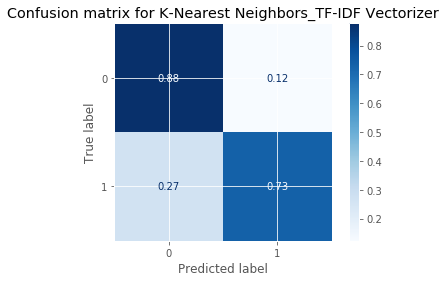

In [73]:
matrix = plot_confusion_matrix(knn_tvec, Xtest_tvec, y_test,
                                 cmap=plt.cm.Blues, normalize='true')
plt.title('Confusion matrix for K-Nearest Neighbors_TF-IDF Vectorizer')
plt.show(matrix)
plt.show()

Confusion Matrix of K-Nearest Neighbors model:
- 55 posts from class 1 'audiobook' was wrongly classified as class 0 'booksuggestions'
- 24 posts from class 0 'booksuggestions' was wrongly classified as class 1 'audiobook'

Compared to confusion matrix of Logistic Regression, there is less no.of false prediction.

### Multinomial Naive Bayes Model_TF-IDF Vectorizer

#### Try Multinomial Naive Bayes with all the default parameters

In [74]:
# Fit and score the model
nb_tvec = MultinomialNB()

nb_tvec.fit(Xtrain_tvec, y_train)

print('MultinomialNB TVEC Training accuracy: ' + str(nb_tvec.score(Xtrain_tvec, y_train)))
print('MultinomialNB TVEC Testing accuracy: ' + str(nb_tvec.score(Xtest_tvec, y_test)))

MultinomialNB TVEC Training accuracy: 0.959445037353255
MultinomialNB TVEC Testing accuracy: 0.8383084577114428


Multinomial Naive Bayes model has higher testing accuracy as compared to K-Nearest Neighbors and Logistic Regression even though it is overfitting.

In [75]:
# Generate a confusion matrix.
confusion_matrix(y_test, nb_tvec.predict(Xtest_tvec))

array([[165,  30],
       [ 35, 172]], dtype=int64)

In [76]:
tn, fp, fn, tp = confusion_matrix(y_test, nb_tvec.predict(Xtest_tvec)).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 165
False Positives: 30
False Negatives: 35
True Positives: 172


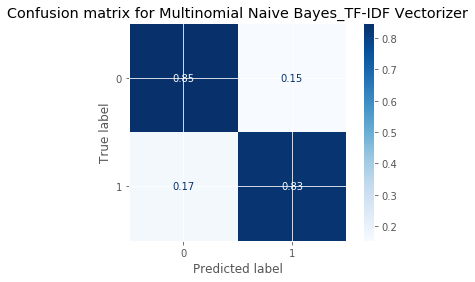

In [77]:
matrix = plot_confusion_matrix(nb_tvec, Xtest_tvec, y_test,
                                 cmap=plt.cm.Blues, normalize='true')
plt.title('Confusion matrix for Multinomial Naive Bayes_TF-IDF Vectorizer')
plt.show(matrix)
plt.show()

Confusion Matrix of Multinomial Naive Bayes model:
- 35 posts from class 1 'audiobook' was wrongly classified as class 0 'booksuggestions'
- 30 posts from class 0 'booksuggestions' was wrongly classified as class 1 'audiobook'

Compared to confusion matrix of all the model built with TVEC, lowest no.of false prediction observed with highest accuracy. Thus, best model with TVEC is Multinomial Naive Bayes.

### Best model with TF-IDF Vectorizer is Multinomial Naive Bayes model.

GridSearch to find the best parameter of TF-IDF Vectorizer and fit into the best model.

In [78]:
# Using pipeline, vectorized with best parameters of vectorizer and fit into the model
pipe = Pipeline([('tvec', TfidfVectorizer()),
                 ('nb', MultinomialNB())])
pipe.get_params()

{'memory': None,
 'steps': [('tvec',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'verbose': False,
 'tvec': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, s

In [79]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {'tvec__max_features':[2000,3000,4000,5000], 'tvec__min_df': [2,3],
               'tvec__max_df': [0.9,0.95], 'tvec__ngram_range': [(1,1),(1,2)]}

In [80]:
# Instantiate GridSearchCV.
gs = GridSearchCV(pipe,param_grid = pipe_params, cv=5) 

# Fit GridSearch to clean_training data.
gs.fit(Xtrain_lem,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [81]:
# Best score
print('TVEC MultinomialNB Best Score: ' + str(gs.best_score_))

# Best hyperparameter used
print('TVEC MultinomialNB Best Hyperparameters: ' + str(gs.best_params_))

TVEC MultinomialNB Best Score: 0.831374445329389
TVEC MultinomialNB Best Hyperparameters: {'tvec__max_df': 0.9, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}


In [82]:
# Save best model as gs_model.
gs_nb_tvec_model = gs.best_estimator_

# Score model on training set.
print('GSTVEC MultinomialNB Training accuracy: ' + str(gs_nb_tvec_model.score(Xtrain_lem, y_train)))

# Score model on testing set.
print('GSTVEC MultinomialNB Testing accuracy: ' + str(gs_nb_tvec_model.score(Xtest_lem, y_test)))

GSTVEC MultinomialNB Training accuracy: 0.9327641408751334
GSTVEC MultinomialNB Testing accuracy: 0.8308457711442786


### Evaluate the models with TF-IDF Vectorizer

TF-IDF Vectorizer with max_features=5000,
- MultinomialNB TVEC Training accuracy: 0.959445037353255
- MultinomialNB TVEC Testing accuracy: 0.8383084577114428

GridSearch TF-IDF Vectorizer with best parameters,
- GSTVEC MultinomialNB Training accuracy: 0.9327641408751334
- GSTVEC MultinomialNB Testing accuracy: 0.8308457711442786

Model of Multinomial Naive Bayes & TF-IDF Vectorizer with max_features=5000 has higher training and testing accuracy. However, this model are more overfit compares to model that with best estimator of TF-IDF vectorizer. Thus, the best model from all the models built with TF-IDF Vectorizer would be Multinomial Naive Bayes with best estimator of TF-IDF vectorizer.

### Best Model Selection

Comparison of best model from two different vectorizers

In [83]:
# Accuracy of the models
print('Accuracy of the Model: ')
print('')
print('MultinomialNB CVEC Training accuracy: ' + str(nb_cvec.score(Xtrain_cvec, y_train)))
print('MultinomialNB CVEC Testing accuracy: ' + str(nb_cvec.score(Xtest_cvec, y_test)))
print('')
print('GSTVEC MultinomialNB Training accuracy: ' + str(gs_nb_tvec_model.score(Xtrain_lem, y_train)))
print('GSTVEC MultinomialNB Testing accuracy: ' + str(gs_nb_tvec_model.score(Xtest_lem, y_test)))


Accuracy of the Model: 

MultinomialNB CVEC Training accuracy: 0.9252934898612594
MultinomialNB CVEC Testing accuracy: 0.8308457711442786

GSTVEC MultinomialNB Training accuracy: 0.9327641408751334
GSTVEC MultinomialNB Testing accuracy: 0.8308457711442786


In [84]:
# Confusion matrix of both model
print('Confusion Matrix of CVEC Multinomial Naive Bayes:')
cvec_mnb_cf = pd.DataFrame(confusion_matrix(y_test, nb_cvec.predict(Xtest_cvec)))
print(cvec_mnb_cf)
print('---------------------------------------------------')
print('Confusion Matrix of TVEC Multinomial Naive Bayes:')
tvec_mnb_cf = pd.DataFrame(confusion_matrix(y_test, gs_nb_tvec_model.predict(Xtest_lem)))
print(tvec_mnb_cf)

Confusion Matrix of CVEC Multinomial Naive Bayes:
     0    1
0  174   21
1   47  160
---------------------------------------------------
Confusion Matrix of TVEC Multinomial Naive Bayes:
     0    1
0  167   28
1   40  167


In [85]:
# Accuracy, Specificity, Sensitivity, Precision

def assp(cf):
    tn,fp,fn,tp = cf.ravel()
    ac = (tp + tn) / (tp + fp + tn + fn)
    sp = tn / (tn + fp)
    se = tp / (tp + fn)
    pr = tp / (tp + fp)
    return print(f'Accuracy:{round(ac,4)}\nSpecificity: {round(sp,4)}\nSensitivity: {round(se,4)}\nPrecision:{round(pr,4)}')

In [86]:
print('CVEC Multinomial Naive Bayes: ')
assp(confusion_matrix(y_test, nb_cvec.predict(Xtest_cvec)))

CVEC Multinomial Naive Bayes: 
Accuracy:0.8308
Specificity: 0.8923
Sensitivity: 0.7729
Precision:0.884


In [87]:
print('TVEC Multinomial Naive Bayes: ')
assp(confusion_matrix(y_test, gs_nb_tvec_model.predict(Xtest_lem)))

TVEC Multinomial Naive Bayes: 
Accuracy:0.8308
Specificity: 0.8564
Sensitivity: 0.8068
Precision:0.8564


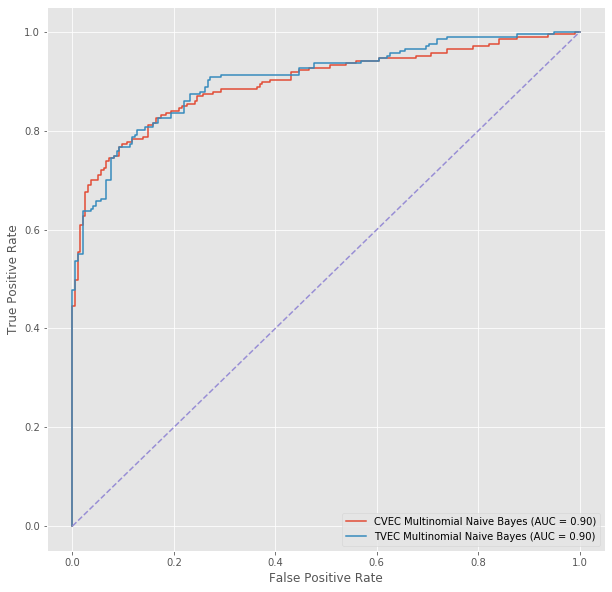

In [91]:
# Plot the ROC curve to check on AUC
fig, ax = plt.subplots(figsize=(10,10));
nb_cvec_plot = plot_roc_curve(nb_cvec, Xtest_cvec, y_test, name='CVEC Multinomial Naive Bayes',ax=ax);
gs_nb_tvec_plot = plot_roc_curve(gs_nb_tvec_model, Xtest_lem, y_test, name='TVEC Multinomial Naive Bayes',ax=nb_cvec_plot.ax_);
plt.plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200), label='baseline', linestyle='--');

### Evaluate the models

Best model criteria:
1. high accuracy (less no.of false calssification)
2. high AUC-Area Under ROC Curve (higher capability of the model on doing classification) 
3. high sensitivity (higher rate to correct classified when it actually belongs to class 1)


### Model 1: CVEC Multinomial Naive Bayes    vs     Model 2: TVEC Multinomial Naive Bayes

In the case of both models have the same accuracy and same AUC, better model should have higher 'sensitivity' so that it would have higher no. of positives classified as positives and this is also to ensure that we dont lose any data from class 1 audiobooks.

By comparing both Model 1 and Model 2, Model 2 has higher sensitivity and high precision. The only downside of Model 2 is having lower specificity which might lead to higher no.of wrongly classified posts from class 0 'booksuggestions' to class 1 'audiobooks'. In our case, false positives will not be the worst condition as we can still get some insight from class 0 'booksuggestions' post.


## Best Model: Model 2: TVEC Multinomial Naive Bayes
TVEC MultinomialNB Best Hyperparameters: {'tvec__max_df': 0.9, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}

### Observation on wrong classification

In [101]:
# display the maximum column width so that able to see the full text
pd.set_option('display.max_colwidth', -1)

C:\Users\xing wei\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [102]:
# Making the classified result dataframe
y_preds = gs_nb_tvec_model.predict(Xtest_lem)
pred_df = pd.DataFrame(y_test)
pred_df['selftext'] = Xtest_lem
pred_df['predict'] = y_preds 
pred_df.head()

,subreddit_bi,selftext,predict
1190,0,inspiration post rory gilmore girl obsession,1
1101,0,looking recommendation thriller mystery novel trying genre pandemic something get engrossed liked many one picked generally loved gillian flynn like especially sharp object recently silent patient thought bad know maybe hot take also finished seven half death evelyn hardcastle also thought okay anyway suggestion high quality page turner would amazing,0
902,0,finished three available elsa hart li du mystery half way name rose worn brad meltzer need new mystery writer hopefully series available front library,1
940,0,hello everyone would like ask recommendation character punishes everyone crime whether small criminal politician owner large corporation character powerful seems impossible defeated least complicated defeated also action necessarily bad show morality interpreted different way malleable,0
1143,0,lot mind lately need fully occupy mind nothing confusing though since probably prompt mind wander edit realized probably state favourite genre fantasy thriller fav author stephen king please graphic rape sex,1


In [103]:
# Display the wrongly classified posts
pred_df.loc[pred_df['subreddit_bi']!=pred_df['predict'],:].sort_values("subreddit_bi",ascending=False)[['subreddit_bi','predict','selftext']]

,subreddit_bi,predict,selftext
623,1,0,long built credit need use first pick neil gaiman neverwhere really like perfect winding end day engaging story relaxed enough narration pare get ready bed credit spend good relax similar way narrator similar style gaiman prefer fiction non fiction especially history
445,1,0,looking siimilar kind worth killing thing female protagonist lead weak overly emotional idiot contains murder want get revenge multiple people wronged someone close confront target deliver vengeance little romance
200,1,0,hello looking scifi focus world building world background drama adventure listened culture series iain bank thanks advance recommendation
64,1,0,movie long lord ring trilogy harry potter series hobbit peter jackson godfather series watching entire thing subtitle convince people pool count getting ready kick track claim prize year
307,1,0,finished third audiodrama alive even though quite long leaf wanting wanting give try would like story similar alive want story zombie zombie like human turned creature example style story wanting smith movie legend video game day gone please recommend wolrd war z looked style story written interest thank recommendation
...,...,...,...
983,0,1,hey wildlife science student emphasis climate change related conservation interested buffing natural science knowledge looking relevant botany ecology wildlife conservation climate change etc far already familiar carl sagan richard dawkins work also salmon without river uninhabitable earth sixth extinction recommended reddit user thanks suggestion
728,0,1,well want take advantage sorta young must getting old suggestion related must know would glad suggestion
1333,0,1,amorphous peter craft amazon trip ghost ghoul demon haunted house indian flesh eating lawn original full amazon buck
875,0,1,find russia fascinating would interested tzar bolshevism collapse soviet union


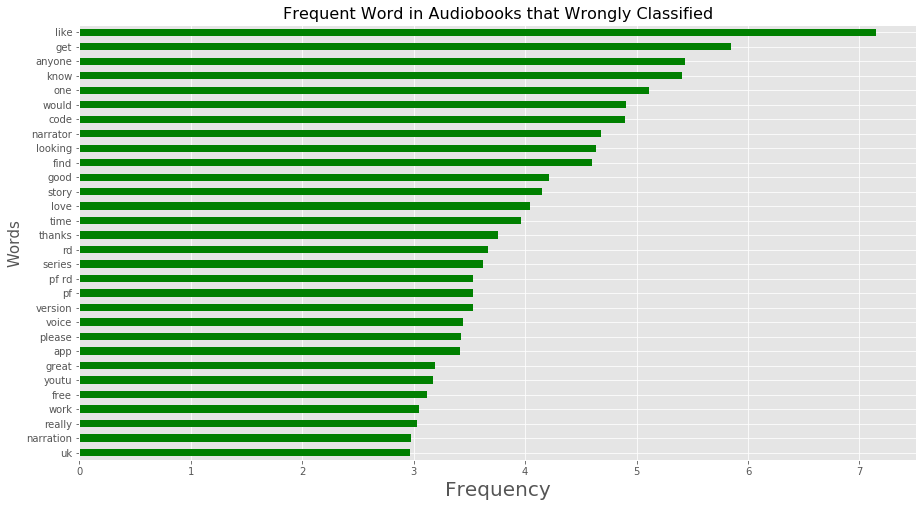

In [104]:
# Check word count in wrong classified posts

# intialized TF-IDF Vectoriser, fit and transform
tvec = TfidfVectorizer(max_df= 0.9, max_features= 3000, min_df= 2, ngram_range= (1, 2))
tvec.fit(pred_df.loc[pred_df['subreddit_bi']==1]['selftext'])
selftext_t = tvec.transform(pred_df.loc[pred_df['subreddit_bi']==1]['selftext'])

# Making it into a DataFrame
selftext_t_df = pd.DataFrame(selftext_t.toarray(),columns = tvec.get_feature_names())
    
# Plot the barchart
plt.figure(figsize=(15,8))
plt.xlabel('Frequency', size = 20)
plt.ylabel('Words', size = 15)
plt.title(f'Frequent Word in Audiobooks that Wrongly Classified', size = 16)
    
selftext_t_df.sum().sort_values(ascending=True).tail(30).plot(kind='barh', color = 'g');  

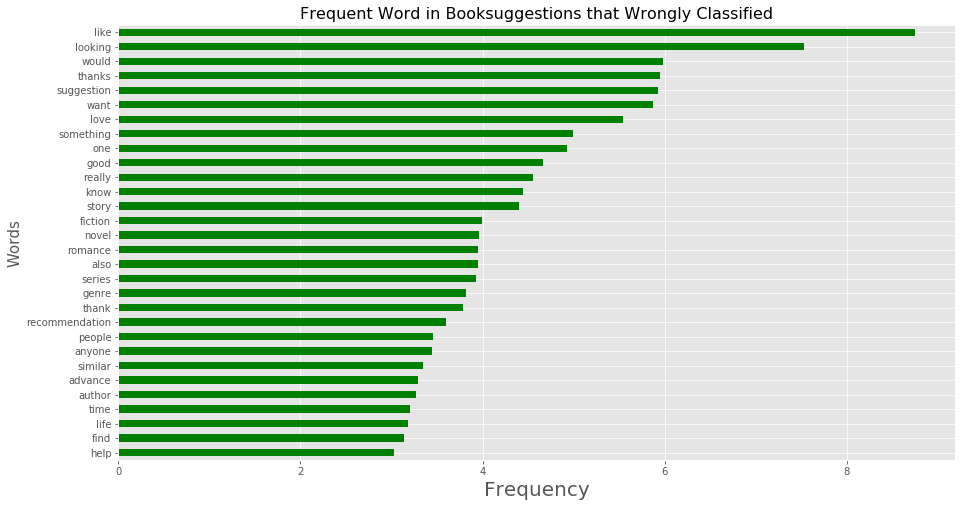

In [105]:
# Check word count in wrong classified posts

# intialized TF-IDF Vectoriser, fit and transform
tvec = TfidfVectorizer(max_df= 0.9, max_features= 3000, min_df= 2, ngram_range= (1, 2))
tvec.fit(pred_df.loc[pred_df['subreddit_bi']==0]['selftext'])
selftext_t = tvec.transform(pred_df.loc[pred_df['subreddit_bi']==0]['selftext'])

# Making it into a DataFrame
selftext_t_df = pd.DataFrame(selftext_t.toarray(),columns = tvec.get_feature_names())
    
# Plot the barchart
plt.figure(figsize=(15,8))
plt.xlabel('Frequency', size = 20)
plt.ylabel('Words', size = 15)
plt.title(f'Frequent Word in Booksuggestions that Wrongly Classified', size = 16)
    
selftext_t_df.sum().sort_values(ascending=True).tail(30).plot(kind='barh', color = 'g');  

Based on the bar chart that display the word count of the wrongly classified posts, the most frequent words that appear in the both subreddits actually are similar to each other, the model would be confused and have higher chance to wrongly classified the posts.

The model can be further improved by removing more words that frequently appear in both subreddits so that the model can be train with more unique words from each subreddit.

## Recommendation & Conclusion

Best model would be Multinomial Naive Bayes with TF-IDF Vectorizer and this model have accuracy of 0.8308 and sensitivity of 0.8068. With this best model, total 68 out of 402 posts was wrongly classified. For further improvement of the model accuracy, we could further remove some of the frequent words that appear in both subreddits.


Based on the classification done with data from subreddits 'audiobooks' and 'booksuggestions', there are some pointers that a publisher can take note of:
1. If the publisher is going to publish an audiobook, the most used audiobook website would be [Audible](https://www.audible.com/). Thus, publishing at the website would be ideal to reach out to more people. 

2. Words like 'Narrator' and 'free' did frequently appear in subreddit 'audiobooks' posts, this can be a hint for the publisher that the narrator's voice and the price of the audiobooks would be the main concern for readers.

3. As the word 'fiction' and 'love' appear to be the preditor of the subreddit 'booksuggestions', publishers can assume that the most popular genres is fiction, non-fiction or love. 

4. As the community in 'booksuggestions' are usually asking for recommendations or suggestions of good books, the sales and marketing team can consider joining the community to advertise new published books by the company.